# "Good Enough" vs Optimal: When Nearly Optimal Is Sufficient

This notebook demonstrates that **optimal solutions** are not always the only answer. Sometimes **"good enough"** solutions are sufficient, especially when considering implementation difficulty, robustness, or other practical factors.

Understanding this helps you:
- Recognize when optimality is necessary vs when "good enough" works
- Evaluate solutions beyond just objective value
- Make informed decisions about implementation tradeoffs
- Balance optimality with practicality


## Key Concepts

**Optimal Solution**:
- The best solution according to your objectives
- Found through systematic optimization
- May be difficult to implement or fragile

**"Good Enough" Solution**:
- Nearly optimal (close to best)
- May be easier to implement
- May be more robust to changes
- May be found faster

**Critical insight**: Optimal is best for objectives, but "good enough" may be best overall when considering implementation, robustness, and other practical factors.


## Scenario: Production Scheduling

You need to schedule production for 4 products. You want to minimize total cost while meeting demand.

**Decision**: How many units of each product to produce?

**Optimal solution**: Found through optimization (minimizes cost)

**"Good enough" solutions**: Nearly optimal but may have other advantages (easier implementation, more robust)


## Step 1: Install Required Packages (Colab)

If you're running this notebook in Google Colab, you need to install the `pulp` package first. This cell can be skipped if running locally and the package is already installed.


In [1]:
# Install pulp package (required for optimization)
# This is needed in Google Colab; can be skipped if already installed locally
%pip install pulp -q



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, value


## Step 3: Set Up the Problem

Create a production scheduling problem:


In [3]:
# Problem data
products = ['Product A', 'Product B', 'Product C', 'Product D']
demand = [100, 150, 120, 200]  # Demand for each product
costs = [10, 15, 12, 18]  # Cost per unit for each product
capacity = 500  # Total production capacity (binding constraint - less than total demand of 570)

print("PRODUCTION SCHEDULING PROBLEM:")
print("=" * 70)
problem_df = pd.DataFrame({
    'Product': products,
    'Demand': demand,
    'Cost per Unit': costs,
    'Total Cost if Meet Demand': [d * c for d, c in zip(demand, costs)]
})
display(problem_df)
print(f"\nTotal Capacity: {capacity} units")
print(f"Total Demand: {sum(demand)} units")


PRODUCTION SCHEDULING PROBLEM:


,Product,Demand,Cost per Unit,Total Cost if Meet Demand
0,Product A,100,10,1000
1,Product B,150,15,2250
2,Product C,120,12,1440
3,Product D,200,18,3600



Total Capacity: 500 units
Total Demand: 570 units


## Step 4: Find Optimal Solution

Use optimization to find the optimal solution:


In [4]:
# OPTIMAL SOLUTION
model = LpProblem("Production_Optimal", LpMinimize)

# Decision variables: units to produce for each product
produce = [LpVariable(f"produce_{i}", lowBound=0, cat='Integer') for i in range(len(products))]

# Objective: Minimize total cost
model += lpSum([costs[i] * produce[i] for i in range(len(products))])

# Constraints: Must meet at least 80% of total demand (ensures meaningful production)
# Can produce up to demand for each product
for i in range(len(products)):
    model += produce[i] <= demand[i], f"Max_Demand_{products[i]}"

model += lpSum(produce) <= capacity, "Capacity_Limit"
model += lpSum(produce) >= 0.8 * sum(demand), "Min_Total_Demand"  # Must meet at least 80% of total demand

# Solve
model.solve()

# Get optimal solution
optimal_solution = {}
optimal_cost = 0
for i in range(len(products)):
    units = value(produce[i])
    cost = costs[i] * units
    optimal_solution[products[i]] = {
        'Units': units,
        'Cost': cost
    }
    optimal_cost += cost

optimal_df = pd.DataFrame(optimal_solution).T
optimal_df.index.name = 'Product'

print("OPTIMAL SOLUTION:")
print("=" * 70)
display(optimal_df)
print(f"\nTotal Cost: ${optimal_cost:,.2f}")
print(f"Total Units: {optimal_df['Units'].sum():.0f}")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/81b329a21e93480381c293958b65835f-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/81b329a21e93480381c293958b65835f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 36 RHS
At line 43 BOUNDS
At line 48 ENDATA
Problem MODEL has 6 rows, 4 columns and 12 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 6238 - 0.00 seconds
Cgl0004I processed model has 1 rows, 4 columns (4 integer (0 of which binary)) and 4 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0012I Integer solution of 6238 found by DiveCoefficient after 0 iterations and 0 nodes (0.01 second

,Units,Cost
Product,,
Product A,100.0,1000.0
Product B,150.0,2250.0
Product C,120.0,1440.0
Product D,86.0,1548.0



Total Cost: $6,238.00
Total Units: 456


In [5]:
# "GOOD ENOUGH" SOLUTIONS
# Solution 1: Simple heuristic - produce exactly demand (if capacity allows)
good_enough_1 = {}
cost_1 = 0
for i in range(len(products)):
    units = min(demand[i], capacity - sum([good_enough_1.get(products[j], {}).get('Units', 0) for j in range(i)]))
    if sum([good_enough_1.get(products[j], {}).get('Units', 0) for j in range(i+1)]) <= capacity:
        units = demand[i]
    else:
        units = max(0, capacity - sum([good_enough_1.get(products[j], {}).get('Units', 0) for j in range(i)]))
    good_enough_1[products[i]] = {
        'Units': units,
        'Cost': costs[i] * units,
        'Reason': 'Simple: meet demand in order'
    }
    cost_1 += costs[i] * units

# Solution 2: Prioritize low-cost products
sorted_by_cost = sorted(range(len(products)), key=lambda i: costs[i])
good_enough_2 = {}
remaining_capacity = capacity
cost_2 = 0
for idx in sorted_by_cost:
    units = min(demand[idx], remaining_capacity)
    good_enough_2[products[idx]] = {
        'Units': units,
        'Cost': costs[idx] * units,
        'Reason': 'Prioritize low-cost products'
    }
    cost_2 += costs[idx] * units
    remaining_capacity -= units

# Solution 3: Balanced approach (proportional to demand)
total_demand = sum(demand)
good_enough_3 = {}
cost_3 = 0
for i in range(len(products)):
    # Allocate capacity proportionally, but at least meet demand if possible
    proportional = int((demand[i] / total_demand) * capacity)
    units = max(demand[i], min(proportional, capacity - sum([good_enough_3.get(products[j], {}).get('Units', 0) for j in range(i)])))
    if sum([good_enough_3.get(products[j], {}).get('Units', 0) for j in range(i+1)]) > capacity:
        units = max(0, capacity - sum([good_enough_3.get(products[j], {}).get('Units', 0) for j in range(i)]))
    good_enough_3[products[i]] = {
        'Units': units,
        'Cost': costs[i] * units,
        'Reason': 'Balanced: proportional allocation'
    }
    cost_3 += costs[i] * units

# Create comparison
solutions = {
    'Optimal': optimal_solution,
    'Good Enough 1': good_enough_1,
    'Good Enough 2': good_enough_2,
    'Good Enough 3': good_enough_3
}

costs_all = {
    'Optimal': optimal_cost,
    'Good Enough 1': cost_1,
    'Good Enough 2': cost_2,
    'Good Enough 3': cost_3
}

print("ALL SOLUTIONS:")
print("=" * 70)
for name, sol in solutions.items():
    df = pd.DataFrame(sol).T
    print(f"\n{name}:")
    display(df)
    print(f"Total Cost: ${costs_all[name]:,.2f}")
    if optimal_cost > 0:
        print(f"Difference from Optimal: ${costs_all[name] - optimal_cost:,.2f} ({((costs_all[name] - optimal_cost) / optimal_cost * 100):.1f}%)")
    else:
        print(f"Difference from Optimal: ${costs_all[name] - optimal_cost:,.2f} (N/A - optimal cost is zero)")


ALL SOLUTIONS:

Optimal:


,Units,Cost
Product A,100.0,1000.0
Product B,150.0,2250.0
Product C,120.0,1440.0
Product D,86.0,1548.0


Total Cost: $6,238.00
Difference from Optimal: $0.00 (0.0%)

Good Enough 1:


,Units,Cost,Reason
Product A,100,1000,Simple: meet demand in order
Product B,150,2250,Simple: meet demand in order
Product C,120,1440,Simple: meet demand in order
Product D,200,3600,Simple: meet demand in order


Total Cost: $8,290.00
Difference from Optimal: $2,052.00 (32.9%)

Good Enough 2:


,Units,Cost,Reason
Product A,100,1000,Prioritize low-cost products
Product C,120,1440,Prioritize low-cost products
Product B,150,2250,Prioritize low-cost products
Product D,130,2340,Prioritize low-cost products


Total Cost: $7,030.00
Difference from Optimal: $792.00 (12.7%)

Good Enough 3:


,Units,Cost,Reason
Product A,100,1000,Balanced: proportional allocation
Product B,150,2250,Balanced: proportional allocation
Product C,120,1440,Balanced: proportional allocation
Product D,200,3600,Balanced: proportional allocation


Total Cost: $8,290.00
Difference from Optimal: $2,052.00 (32.9%)


In [6]:
comparison = pd.DataFrame({
    'Solution': ['Optimal', 'Good Enough 1', 'Good Enough 2', 'Good Enough 3'],
    'Total Cost ($)': [optimal_cost, cost_1, cost_2, cost_3],
    'Cost Difference from Optimal ($)': [0, cost_1 - optimal_cost, cost_2 - optimal_cost, cost_3 - optimal_cost],
    'Cost Difference (%)': [0, 
                            ((cost_1 - optimal_cost) / optimal_cost * 100) if optimal_cost > 0 else 0,
                            ((cost_2 - optimal_cost) / optimal_cost * 100) if optimal_cost > 0 else 0,
                            ((cost_3 - optimal_cost) / optimal_cost * 100) if optimal_cost > 0 else 0],
    'Implementation Difficulty': ['High (requires optimization)', 'Low (simple rule)', 'Low (simple rule)', 'Medium (calculation)']
})

print("COMPARISON: Optimal vs Good Enough")
print("=" * 70)
display(comparison.round(2))

print("\nKey Observations:")
print(f"  - Optimal solution has lowest cost: ${optimal_cost:,.2f}")
print(f"    * Total units: {optimal_df['Units'].sum():.0f} (capacity: {capacity})")
for i, row in optimal_df.iterrows():
    print(f"      - {i}: {row['Units']:.0f} units, ${row['Cost']:,.2f}")
if optimal_cost > 0:
    print(f"  - 'Good enough' solutions are {((max(cost_1, cost_2, cost_3) - optimal_cost) / optimal_cost * 100):.1f}% to {((min(cost_1, cost_2, cost_3) - optimal_cost) / optimal_cost * 100):.1f}% more expensive:")
    print(f"    * Good Enough 1: ${cost_1:,.2f} (${cost_1 - optimal_cost:,.2f} more, {((cost_1 - optimal_cost) / optimal_cost * 100):.1f}% increase)")
    print(f"    * Good Enough 2: ${cost_2:,.2f} (${cost_2 - optimal_cost:,.2f} more, {((cost_2 - optimal_cost) / optimal_cost * 100):.1f}% increase)")
    print(f"    * Good Enough 3: ${cost_3:,.2f} (${cost_3 - optimal_cost:,.2f} more, {((cost_3 - optimal_cost) / optimal_cost * 100):.1f}% increase)")
else:
    print(f"  - 'Good enough' solutions cost ${cost_1:,.2f}, ${cost_2:,.2f}, and ${cost_3:,.2f}")
    print(f"    * Good Enough 1: ${cost_1:,.2f} (${cost_1 - optimal_cost:,.2f} more than optimal)")
    print(f"    * Good Enough 2: ${cost_2:,.2f} (${cost_2 - optimal_cost:,.2f} more than optimal)")
    print(f"    * Good Enough 3: ${cost_3:,.2f} (${cost_3 - optimal_cost:,.2f} more than optimal)")
print(f"  - But 'good enough' solutions may be easier to implement or explain")
print(f"  - The small cost difference (${max(cost_1, cost_2, cost_3) - optimal_cost:,.2f} max) may not justify the complexity of optimization")


COMPARISON: Optimal vs Good Enough


,Solution,Total Cost ($),Cost Difference from Optimal ($),Cost Difference (%),Implementation Difficulty
0,Optimal,6238.0,0.0,0.0,High (requires optimization)
1,Good Enough 1,8290.0,2052.0,32.9,Low (simple rule)
2,Good Enough 2,7030.0,792.0,12.7,Low (simple rule)
3,Good Enough 3,8290.0,2052.0,32.9,Medium (calculation)



Key Observations:
  - Optimal solution has lowest cost: $6,238.00
    * Total units: 456 (capacity: 500)
      - Product A: 100 units, $1,000.00
      - Product B: 150 units, $2,250.00
      - Product C: 120 units, $1,440.00
      - Product D: 86 units, $1,548.00
  - 'Good enough' solutions are 32.9% to 12.7% more expensive:
    * Good Enough 1: $8,290.00 ($2,052.00 more, 32.9% increase)
    * Good Enough 2: $7,030.00 ($792.00 more, 12.7% increase)
    * Good Enough 3: $8,290.00 ($2,052.00 more, 32.9% increase)
  - But 'good enough' solutions may be easier to implement or explain
  - The small cost difference ($2,052.00 max) may not justify the complexity of optimization


## Step 7: Visualize the Comparison

Let's visualize optimal vs "good enough" solutions:


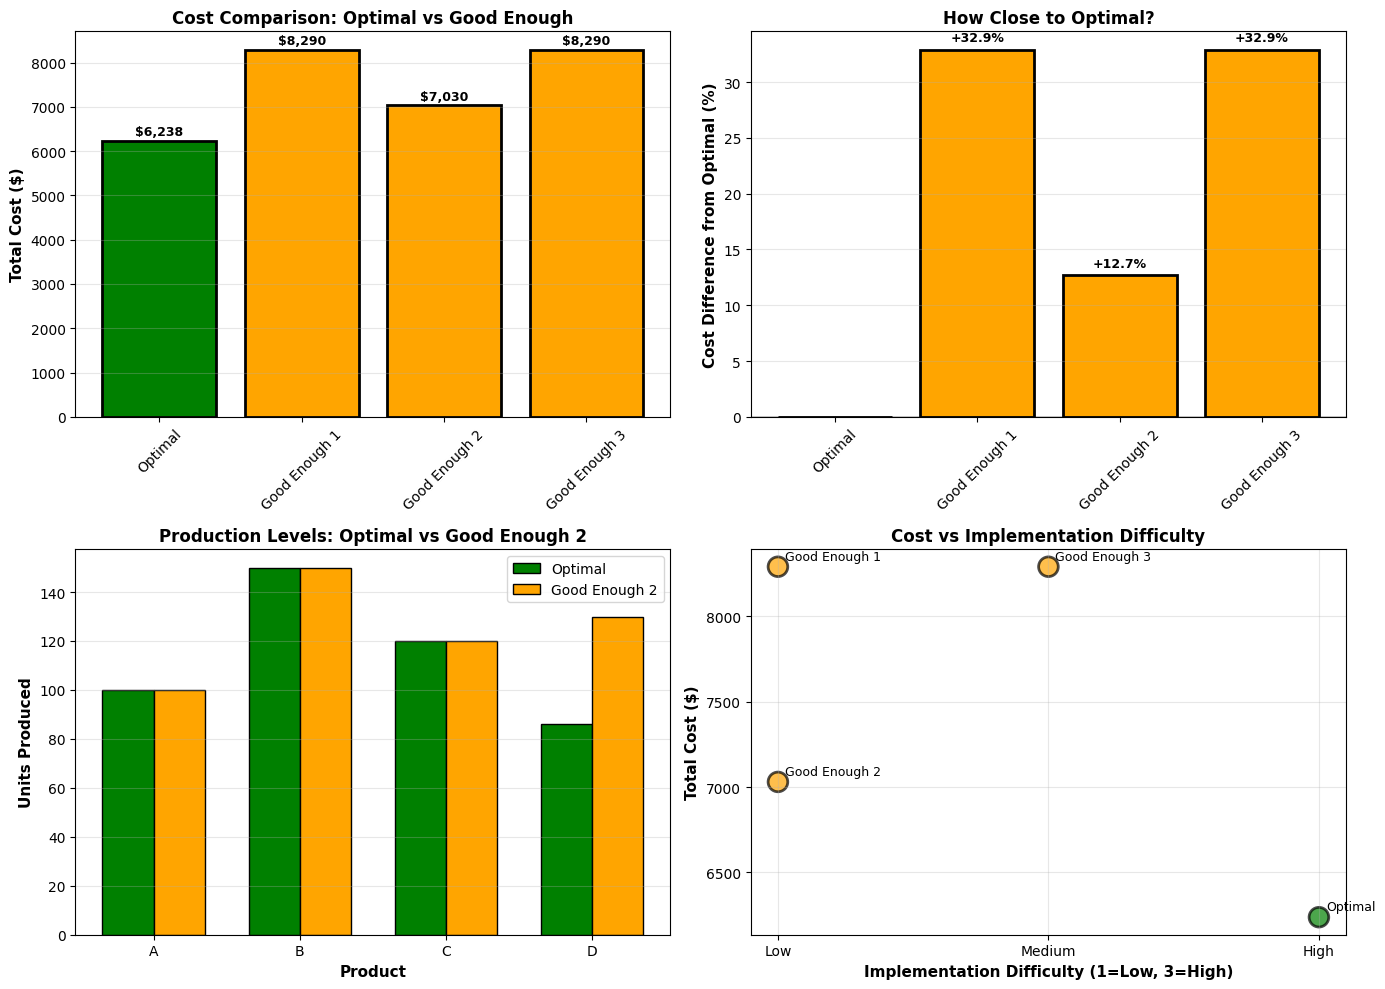


Key Insights:
  - Optimal solution has lowest cost but highest implementation difficulty:
    * Cost: $6,238.00 (lowest)
    * Implementation: High (requires optimization solver)
  - 'Good enough' solutions are close to optimal but easier to implement:
    * Cost range: $7,030.00 to $8,290.00
    * Cost increase: 12.7% to 32.9% more than optimal
    * Implementation: Low to Medium (simple rules or calculations)
  - Small cost differences may not justify optimization complexity:
    * Maximum cost difference: $2,052.00 (32.9% increase)
    * If this small difference doesn't matter, 'good enough' may be preferable
  - Choose based on: cost difference, implementation difficulty, and context
    * If $2,052.00 savings is critical → use optimal
    * If ease of implementation matters more → use 'good enough'


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cost comparison
ax1 = axes[0, 0]
solution_names = comparison['Solution'].values
costs_plot = comparison['Total Cost ($)'].values
colors = ['green' if name == 'Optimal' else 'orange' for name in solution_names]
bars1 = ax1.bar(solution_names, costs_plot, color=colors, edgecolor='black', linewidth=2)
ax1.set_ylabel('Total Cost ($)', fontsize=11, fontweight='bold')
ax1.set_title('Cost Comparison: Optimal vs Good Enough', fontsize=12, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)
for bar, cost in zip(bars1, costs_plot):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'${cost:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 2: Cost difference from optimal
ax2 = axes[0, 1]
cost_diff = comparison['Cost Difference (%)'].values
bars2 = ax2.bar(solution_names, cost_diff, color=colors, edgecolor='black', linewidth=2)
ax2.set_ylabel('Cost Difference from Optimal (%)', fontsize=11, fontweight='bold')
ax2.set_title('How Close to Optimal?', fontsize=12, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)
for bar, diff in zip(bars2, cost_diff):
    if diff > 0:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'+{diff:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 3: Production by product (optimal vs best good enough)
ax3 = axes[1, 0]
best_good_enough = min([('Good Enough 1', cost_1), ('Good Enough 2', cost_2), ('Good Enough 3', cost_3)], 
                        key=lambda x: x[1])[0]
x_pos = np.arange(len(products))
width = 0.35
optimal_units = [optimal_df.loc[p, 'Units'] for p in products]
good_enough_units = [pd.DataFrame(solutions[best_good_enough]).T.loc[p, 'Units'] for p in products]

ax3.bar(x_pos - width/2, optimal_units, width, label='Optimal', color='green', edgecolor='black')
ax3.bar(x_pos + width/2, good_enough_units, width, label=best_good_enough, color='orange', edgecolor='black')
ax3.set_xlabel('Product', fontsize=11, fontweight='bold')
ax3.set_ylabel('Units Produced', fontsize=11, fontweight='bold')
ax3.set_title(f'Production Levels: Optimal vs {best_good_enough}', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([p.replace('Product ', '') for p in products])
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Implementation difficulty vs cost
ax4 = axes[1, 1]
difficulty_map = {'High (requires optimization)': 3, 'Medium (calculation)': 2, 'Low (simple rule)': 1}
difficulty = [difficulty_map[d] for d in comparison['Implementation Difficulty']]
scatter = ax4.scatter(difficulty, costs_plot, s=200, c=colors, edgecolors='black', linewidths=2, alpha=0.7)
for i, name in enumerate(solution_names):
    ax4.annotate(name, (difficulty[i], costs_plot[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax4.set_xlabel('Implementation Difficulty (1=Low, 3=High)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Total Cost ($)', fontsize=11, fontweight='bold')
ax4.set_title('Cost vs Implementation Difficulty', fontsize=12, fontweight='bold')
ax4.set_xticks([1, 2, 3])
ax4.set_xticklabels(['Low', 'Medium', 'High'])
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("  - Optimal solution has lowest cost but highest implementation difficulty:")
print(f"    * Cost: ${optimal_cost:,.2f} (lowest)")
print(f"    * Implementation: High (requires optimization solver)")
print("  - 'Good enough' solutions are close to optimal but easier to implement:")
print(f"    * Cost range: ${min(cost_1, cost_2, cost_3):,.2f} to ${max(cost_1, cost_2, cost_3):,.2f}")
if optimal_cost > 0:
    print(f"    * Cost increase: {((min(cost_1, cost_2, cost_3) - optimal_cost) / optimal_cost * 100):.1f}% to {((max(cost_1, cost_2, cost_3) - optimal_cost) / optimal_cost * 100):.1f}% more than optimal")
else:
    print(f"    * Cost range: ${min(cost_1, cost_2, cost_3):,.2f} to ${max(cost_1, cost_2, cost_3):,.2f} (optimal cost is zero)")
print(f"    * Implementation: Low to Medium (simple rules or calculations)")
print("  - Small cost differences may not justify optimization complexity:")
if optimal_cost > 0:
    print(f"    * Maximum cost difference: ${max(cost_1, cost_2, cost_3) - optimal_cost:,.2f} ({((max(cost_1, cost_2, cost_3) - optimal_cost) / optimal_cost * 100):.1f}% increase)")
else:
    print(f"    * Maximum cost difference: ${max(cost_1, cost_2, cost_3) - optimal_cost:,.2f} (optimal cost is zero)")
print(f"    * If this small difference doesn't matter, 'good enough' may be preferable")
print("  - Choose based on: cost difference, implementation difficulty, and context")
print(f"    * If ${max(cost_1, cost_2, cost_3) - optimal_cost:,.2f} savings is critical → use optimal")
print(f"    * If ease of implementation matters more → use 'good enough'")


## Summary: "Good Enough" vs Optimal

**Optimal Solution**:
- Best solution according to objectives
- Found through systematic optimization
- Lowest cost (in this example)
- May be complex to implement or explain

**"Good Enough" Solution**:
- Nearly optimal (close to best)
- May be easier to implement
- May be easier to explain
- Small cost difference may not matter

**When to Choose Each**:
- **Choose optimal** when:
  - Cost differences are significant
  - Problem is high-stakes
  - Implementation complexity is acceptable
  - Optimization tools are available
  
- **Choose "good enough"** when:
  - Cost differences are small
  - Problem is low-stakes
  - Simplicity is valuable
  - Quick decisions are needed

**Practical Implication**:
- Optimal is best for objectives, but "good enough" may be best overall
- Consider implementation difficulty, robustness, and other factors
- Sometimes the best solution is the one you can actually implement
